In [1]:
import os
import time
import copy

import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

plt.ion()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
train_dataset = datasets.MNIST('mnist', transform=transform, train=True, download=True)
test_dataset = datasets.MNIST('mnist', transform=transform, train=False, download=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [4]:
device = "cpu"# torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)

In [6]:
train_inputs, train_labels = next(iter(train_loader))
test_inputs, test_labels = next(iter(test_loader))

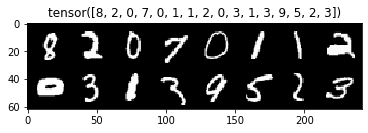

In [7]:
train_out = torchvision.utils.make_grid(train_inputs)

imshow(train_out, train_labels)

In [8]:
def generate_model():
    return nn.Sequential(
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.LogSoftmax(dim=1)
    )

In [9]:
def train(train_loader):
    model = generate_model()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    best_loss = 0
    losses = []

    for e in range(10):
        running_loss = 0
        for data in train_loader:
            #images.to(device)
            #labels.to(device)

            images, labels = data[0].to(device), data[1].to(device)

            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            #This is where the model learns by backpropagating
            loss.backward()

            #And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
            
            if e == 0:
                best_loss = running_loss
            else:
                if running_loss < best_loss:
                    best_loss = running_loss
                    torch.save(model.state_dict(), 'best_mnist_w.pt')
                    print("Epoch {} - Training loss: {}".format(e, running_loss / len(train_loader)))
        
        losses.append(running_loss / len(train_loader))

    return losses

In [10]:
def validate(test_loader):
    model = generate_model()
    model = model.to(device)
    model.load_state_dict(torch.load('best_mnist_w.pt'))

    correct = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data[0].to(device), data[1].to(device)

            if i == 0:
                img_view = torchvision.utils.make_grid(images[:10])
                imshow(img_view.cpu(), labels[:10].cpu())

            images = images.view(images.shape[0], -1)

            output = model(images)
            _, preds = torch.max(output, 1)

            correct += (len(labels) - len(torch.nonzero(preds - labels)))

            print(correct / len(test_loader.dataset))

In [11]:
losses = train(train_loader)

Epoch 1 - Training loss: 3.858186304569244e-06
Epoch 8 - Training loss: 1.1830095201730727e-06
Epoch 9 - Training loss: 1.704649068415165e-07


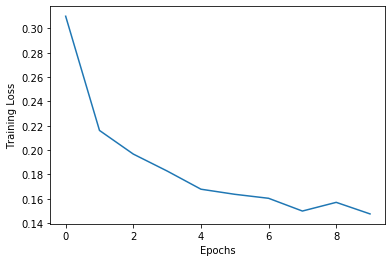

In [17]:
fig = plt.figure()
ax = plt.axes()

plt.xlabel('Epochs')
plt.ylabel('Training Loss')

ax.plot([x for x in range(10)], losses)